# **Classifying Movie Reviews**

In [70]:
# Import packages/modules for data processing
import pandas as pd
import numpy as np
from collections import defaultdict
import copy
np.random.seed(4)
import random
import re
import string
import pickle

# import packages/modules for plotting/data viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('ggplot')
import seaborn as sns


from wordcloud import WordCloud, STOPWORDS
import string
from nltk.corpus import stopwords as nltk_stopwords
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

# import packages/modules for modelling
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, precision_recall_curve, average_precision_score, recall_score, precision_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix as plot_cm, roc_curve, auc, f1_score, precision_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold,RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import itertools
from itertools import cycle
import scipy
from scipy import interp
from scipy.stats import loguniform, reciprocal, uniform

In [13]:
data = pd.read_csv('/Users/hudsonfinchbatista/Desktop/moviereviews2.tsv', sep='\t')
data.head()

,label,review
0,pos,I loved this movie and will watch it again. Or...
1,pos,"A warm, touching movie that has a fantasy-like..."
2,pos,I was not expecting the powerful filmmaking ex...
3,neg,"This so-called ""documentary"" tries to tell tha..."
4,pos,This show has been my escape from reality for ...


In [14]:
data.isnull().sum()

label      0
review    20
dtype: int64

In [15]:
data = data.dropna()
data.isnull().sum()

label     0
review    0
dtype: int64

In [16]:
data['label'].value_counts()

neg    2990
pos    2990
Name: label, dtype: int64

In [21]:
def text_preprocessor(features):
    processed_features = []

    for i in range(0, len(features)):
        # Remove all the special characters
        processed_feature = re.sub(r'\W', ' ', str(features[i]))

        # remove all single characters
        processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

        # Remove single characters from the start
        processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features.append(processed_feature)

    return processed_features

The most common words for reviews with pos sentiment are:



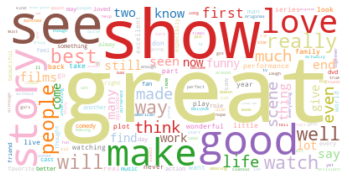

The most common words for reviews with neg sentiment are:



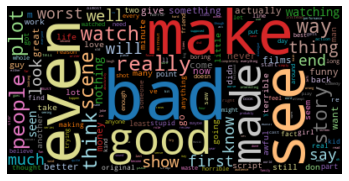

In [26]:
stopwords = set(STOPWORDS)
stopwords.update(['movie', 'film', 'character', 'actor', 'character', 'acting', 'director',
                 'characters', 'actors', 'br', 'one', 'time', 'movies'])
sentiments = ['pos', 'neg']
full_text_list = []
colors = ['white', 'black']

for sent in sentiments:
    text_data = data[data['label'] == sent]
    features = text_data.loc[:,['review']].values
    processed_text = text_preprocessor(features)
    full_text = " ".join(text for text in processed_text)
    full_text_list.append(full_text)
            
for sent, lst, color in zip(sentiments, full_text_list, colors):
    
    print(f'The most common words for reviews with {sent} sentiment are:\n')
    
    wordcloud = WordCloud(stopwords=stopwords, colormap='tab20',
                          background_color=color).generate(lst)
    
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [31]:
len(data['review'][0].split())

45

In [36]:
## Create a column that gives the number of words for each review
data['Num_Words_Review'] = data['review'].apply(lambda x: len(x.split()))

## Create variable that categorizes or bins the number of words for each review
data['Bins'] = pd.cut(data['Num_Words_Review'], bins=[0, 30, 60, 90, 120, 150, 180, 210, 
                                                      240, 270, 300, 330, 360, 390, 420, 
                                                      450, 480], 
                      labels=['0-30','30-60','60-90','90-120','120-150','150-180','180-210',
                              '210-240', '240-270', '270-300', '300-330', '330-360', 
                             '360-390', '390-420', '420-450', '450-480'])

## Group the data by bin counts
word_dist = data.groupby('Bins').size().reset_index().rename(columns={0:'Counts'})

word_dist

,Bins,Counts
0,0-30,24
1,30-60,356
2,60-90,434
3,90-120,725
4,120-150,1417
5,150-180,831
6,180-210,588
7,210-240,421
8,240-270,327
9,270-300,238


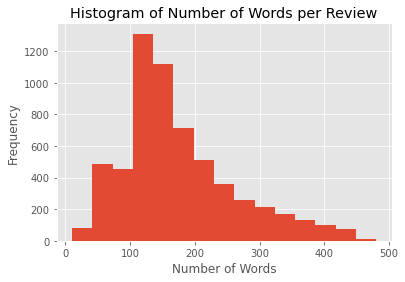

In [40]:
plt.hist(data['Num_Words_Review'],bins=15)
plt.title('Histogram of Number of Words per Review')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [52]:
rev_len_sent = data.groupby(['Bins','label'])['review'].count().unstack().reset_index()
rev_len_sent

label,Bins,neg,pos
0,0-30,9,15
1,30-60,136,220
2,60-90,196,238
3,90-120,343,382
4,120-150,742,675
5,150-180,438,393
6,180-210,313,275
7,210-240,199,222
8,240-270,167,160
9,270-300,121,117


In [41]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=7, max_df=0.8, 
                             stop_words=nltk_stopwords.words('english'))

In [42]:
features = data.loc[:,['review']].values

processed_features = text_preprocessor(features)
    
processed_features[0]

' loved this movie and will watch it again original twist to plot of man vs man vs self think this is kurt russell best movie his eyes conveyed more than most actors words perhaps there hope for mankind in spite of government intervention '

In [43]:
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [44]:
le = preprocessing.LabelEncoder()

labels = le.fit_transform(data['label'])

In [53]:
train, test, train_labels, test_labels = train_test_split(processed_features, labels, test_size=0.2, random_state=0)


In [56]:
# model for optimizing hyperparameters

def optimize_params(train, train_labels, rs):
    
    rs.fit(train, train_labels)
    model = rs.best_estimator_
    
    return model

In [58]:
# 1. Random Forest Model

param_grid = {
    'n_estimators': np.linspace(10,200).astype(int),
    'max_depth': list(np.linspace(3,30).astype(int)),
    'max_features': ['auto','sqrt'] + list(np.arange(0.3,1,0.1)),
    'max_leaf_nodes': list(np.linspace(10,50,500).astype(int)),
    'min_samples_split': [2,5,10,15,20],
    'bootstrap': [True,False]
}

rf_estimator = RandomForestClassifier(random_state=4)

rf = RandomizedSearchCV(rf_estimator, param_grid, n_jobs=-1, cv=KFold(5, random_state=4, 
                                                                      shuffle=True), 
                        n_iter=10, verbose = 3, scoring='roc_auc')

best_rf = optimize_params(train, train_labels, rf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 25.6min finished


In [59]:
# 2. Logistic Regression Model

# Create Instance of Model
logreg = LogisticRegression(random_state = 4)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=4)

rs_logreg = RandomizedSearchCV(logreg, space, n_iter=10, scoring='roc_auc', 
                            n_jobs=-1, cv=cv, random_state=4)

best_log = optimize_params(train, train_labels, rs_logreg)

In [60]:
# 3. Extreme Gradient Boosted Machine Model

xgb = XGBClassifier(random_state=4)

param_grid2 = {
    'n_estimators': np.linspace(10,200).astype(int),
    'max_depth': [None] + list(np.linspace(3,20).astype(int)),
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree' : [0.3, 0.5, 0.7],
}


rs_xgb = RandomizedSearchCV(xgb, param_grid2, cv=KFold(3, random_state=4, shuffle=True),
                            n_iter=10, random_state=4, scoring='roc_auc', n_jobs=-1)

best_xgb = optimize_params(train, train_labels, rs_xgb)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:54:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [61]:
# 4. Light Gradient Boosted Machine Model

lgbm = LGBMClassifier(random_state=4)

param_grid3 = {'n_estimators': np.linspace(0,200).astype(int),
              'max_depth': [None] + list(np.linspace(3,20).astype(int)),
              'learning_rate': [0.01, 0.1, 0.2],
               'colsample_bytree' : [0.5, 0.7, 0.9],
               'subsample':[0.5, 0.7, 0.9],
               'num_leaves': np.arange(20,3000,20)
              }

rs_lgbm = RandomizedSearchCV(lgbm, param_grid3, cv=KFold(3, random_state=4, shuffle=True), 
                             n_iter=10,random_state=4, scoring='neg_log_loss', n_jobs=-1)
            
best_lgbm = optimize_params(train, train_labels, rs_lgbm)

In [66]:
comb_model = VotingClassifier(estimators=[('rf', best_rf), ('lf', best_log), 
                                          ('xgb', best_xgb), ('lgbm', best_lgbm)], 
                         voting='soft')

comb_model.fit(train, train_labels)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:02:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=23,
                                                     max_features=0.6000000000000001,
                                                     max_leaf_nodes=36,
                                                     min_samples_split=5,
                                                     n_estimators=48,
                                                     random_state=4)),
                             ('lf',
                              LogisticRegression(C=0.765776037159086,
                                                 random_state=4,
                                                 solver='newton-cg')),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                      

In [67]:
# Create Predictions and Evaluate Models on Test Data

model_types = ['Random Forest', 'Logistic Regression', 'Extreme Gradient Boosted Machine',
              'Light Gradient Boosted Machine', 'Ensemble Model']

models = [best_rf, best_log, best_xgb, best_lgbm, comb_model]
model_metrics = defaultdict(list)

for model, model_type in zip(models, model_types):
    preds = model.predict(test)
    probs = model.predict_proba(test)
    acc = accuracy_score(test_labels, preds)
    recall = recall_score(test_labels, preds, average='binary')
    prec = precision_score(test_labels, preds, average='binary')
    f1 = f1_score(test_labels, preds)
    auc = roc_auc_score(test_labels, probs[:,1])
    loss = log_loss(test_labels, probs)
    metrics = [acc, prec, recall, f1, auc, loss]
    model_metrics[model_type] = metrics

In [68]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df.index = ['Accuracy', 'Precision', 'Recall', 'F1 Score',
                         'ROC AUC', 'Log Loss']
model_metrics_df

,Random Forest,Logistic Regression,Extreme Gradient Boosted Machine,Light Gradient Boosted Machine,Ensemble Model
Accuracy,0.782609,0.900502,0.872074,0.870401,0.872910
Precision,0.764241,0.877583,0.847244,0.846761,0.849684
Recall,0.813131,0.929293,0.905724,0.902357,0.904040
F1 Score,0.787928,0.902698,0.875509,0.873676,0.876020
ROC AUC,0.874446,0.959683,0.942951,0.945460,0.947761
Log Loss,0.454156,0.341179,0.310410,0.298341,0.321183


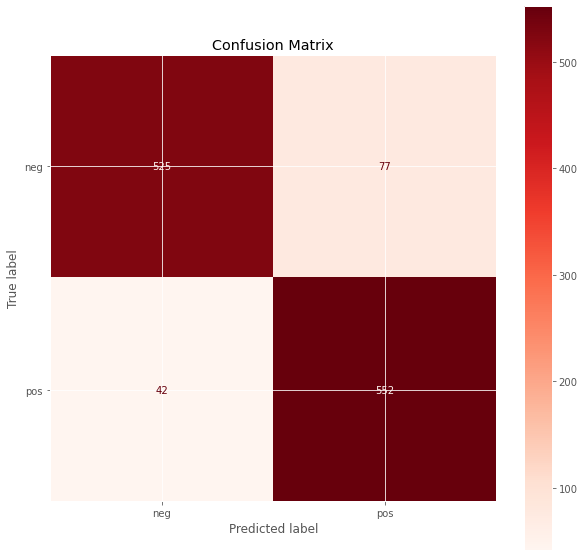

In [76]:
display_labels = ['neg', 'pos']

plot_cm(best_log, test, test_labels, display_labels = display_labels, cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

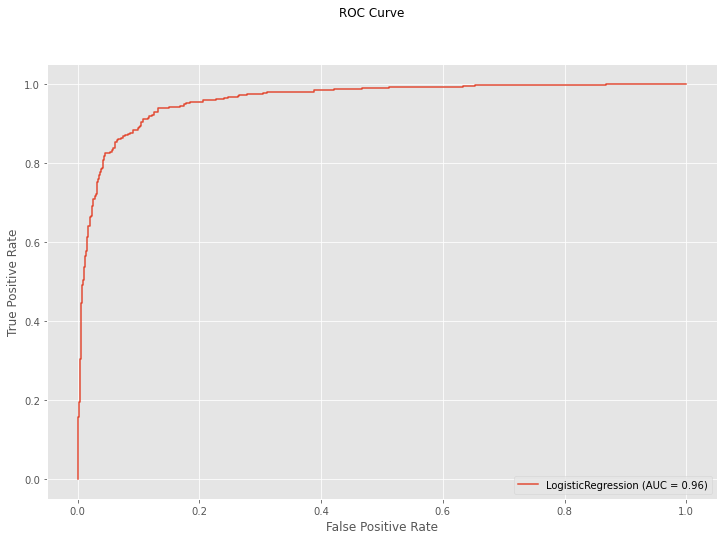

In [78]:
disp = plot_roc_curve(best_log, test, test_labels)
disp.figure_.suptitle("ROC Curve")
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [79]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))